In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


In [2]:
%matplotlib inline
from __future__ import division, print_function

In [3]:
import math
import numpy as np
import random
import sys

from numpy.random import normal
import matplotlib.pyplot as plt

In [4]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Embedding, Activation, merge, Flatten, Dropout, Lambda
from keras.layers import LSTM, SimpleRNN, TimeDistributed
from keras.models import Model, Sequential
from keras.layers.merge import Add, add
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.constraints import nonneg
from keras.layers.convolutional import *
from keras import backend as K
from keras.utils.data_utils import get_file

Using Theano backend.


In [449]:
look_back = 12
batch_size = 1

In [450]:
def mllklh(args): # minus log-likelihood of gaussian
    var_t, eps2_t = args
    return 0.5*math.log(2*math.pi) + 0.5*K.log(var_t)  + 0.5*(eps2_t/var_t)

In [452]:
#len(Xs), Xs[0].shape, modelUNR.predict([X[10:15,0] for X in Xs]).shape

### RNN architecture : 2 models that share same weights

In [455]:
MatPlus = np.zeros((look_back-1,look_back))
MatPlus[:,1:] = np.eye(look_back-1)
#print(MatPlus)

MatMinus = np.zeros((look_back-1,look_back))
MatMinus[:,:-1] = np.eye(look_back-1)
#print(MatMinus)

In [456]:
Dplus = Dense(look_back-1,
              weights=[MatPlus.T, np.zeros((look_back-1,))],
              input_dim=look_back)
Dplus.trainable = False

Dminus = Dense(look_back-1,
              weights=[MatMinus.T, np.zeros((look_back-1,))],
              input_dim=look_back)
Dminus.trainable = False

In [909]:
I = Input(batch_shape=(batch_size, look_back,1), dtype='float32')
I2 = Lambda(lambda x : K.square(x), output_shape=(look_back,1))(I)
rnn = SimpleRNN(return_sequences=True, unroll=False,
                units=1, input_shape=(look_back, 1),
                bias_constraint=nonneg(), # insure positive var
                kernel_constraint=nonneg(), # insure positive var
                recurrent_constraint=nonneg(), # insure positive var
                activation=None,
                stateful=True)
O1 = rnn(I2)
O1f = Flatten()(O1)
O1m = Dminus(O1f)

V = Lambda(lambda x : K.sqrt(x), output_shape=(look_back,))(O1f) # get volatility

I2f = Flatten()(I2)
I2p = Dplus(I2f)

Errors = Lambda(mllklh, output_shape=(look_back-1,))([O1m,I2p])

Error = Lambda(lambda x : K.sum(x, axis=1), output_shape=(look_back-1,))(Errors)

modelT = Model(inputs=I, outputs=Errors) # training model

def special_loss(dummy, errorterms):
    return errorterms

modelT.compile(optimizer='adadelta', loss=special_loss)

modelV = Model(inputs=I, outputs=V) # simulation model

In [910]:
Dplus.get_weights()[0].shape, Dplus.get_weights()[1].shape

((12, 11), (11,))

In [911]:
I._keras_shape, I2._keras_shape, O1._keras_shape, O1f._keras_shape, V._keras_shape, Errors._keras_shape, Error._keras_shape

((1, 12, 1), (1, 12, 1), (1, 12, 1), (1, 12), (1, 12), (1, 11), (1, 11))

In [912]:
onearr = np.ones((batch_size, look_back, 1)).astype('float32')
print(I2.eval({I:onearr}).shape)
print(O1.eval({I:onearr}).shape)
print(O1f.eval({I:onearr}).shape)
print(V.eval({I:onearr}).shape)
print(Errors.eval({I:onearr}).shape)
print(Error.eval({I:onearr}).shape)
print(modelT.predict(onearr).shape)
print(modelV.predict(onearr).shape)

(1, 12, 1)
(1, 12, 1)
(1, 12)
(1, 12)
(1, 11)
(1,)
(1, 11)
(1, 12)


In [913]:
rnn(I2).eval({I:onearr}) # dry run to allow weight setting
rnn.set_weights([np.array([[0.5]]),np.array([[1]]),np.array([1.5])])
print( O1f.eval({I:onearr}) )
print( O1m.eval({I:onearr}) )

[[  2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.]]
[[  2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.]]


In [914]:
#print( I2f.eval({I:onearr}) )
#print( I2p.eval({I:onearr}) )

In [915]:
Error.eval({I:onearr}).shape

(1,)

In [916]:
modelT.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (1, 12, 1)            0                                            
____________________________________________________________________________________________________
lambda_33 (Lambda)               (1, 12, 1)            0                                            
____________________________________________________________________________________________________
simple_rnn_9 (SimpleRNN)         (1, 12, 1)            3                                            
____________________________________________________________________________________________________
flatten_17 (Flatten)             (1, 12)               0                                            
___________________________________________________________________________________________

#### Manually specify a GARCH model

In [917]:
kappa = 0.000003
alpha = 0.85
beta = 0.10
lvar = kappa / (1-alpha-beta)
print(math.sqrt(lvar)*math.sqrt(255))

0.123693168769


#### Copy the known GARCH parameters as initial weights for the RNN

In [918]:
math.sqrt(lvar) # standard deviation of simulated data set

0.007745966692414833

In [919]:
F = 1/math.sqrt(lvar) # will have to scale training data by F and Kappa by F^2 (alpha and beta unchanged)

In [920]:
rnn(I2).eval({I:onearr}) # dry run to allow weight setting
rnn.set_weights([np.array([[beta]]),np.array([[alpha]]),np.array([kappa])*F*F])

#### Simulate the GARCH dynamic

In [921]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, allow_overlap=True):
    dataX, dataY = [], []
    if allow_overlap:
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    else:
        # non overlap
        for i in range(0, int(dataset.shape[0]/batch_size)*batch_size-look_back, look_back):
            #print(i)
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

train = []
trainvars = []
var_t = lvar
for t in range(250*8):
    eps = math.sqrt(var_t) * normal()
    var_t = kappa + alpha * var_t + beta * (eps*eps)
    train.append(eps) # percent
    trainvars.append(var_t)
train = np.array(train).reshape(-1,1)
trainX, trainY = create_dataset(train, look_back, allow_overlap=False)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#print(trainX, trainY)

In [922]:
trainX.shape, trainY.shape, trainX.transpose((0,2,1)).shape

((166, 1, 12), (166,), (166, 12, 1))

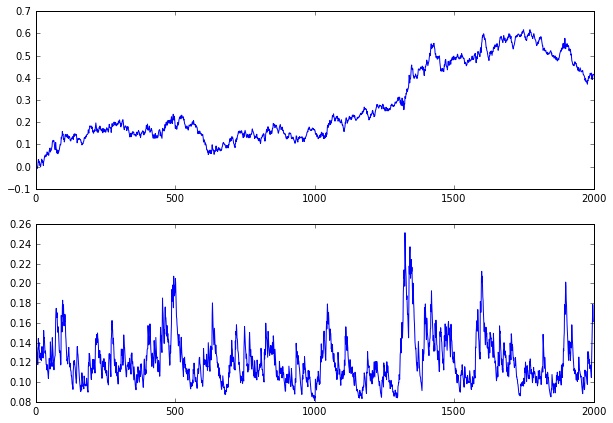

In [923]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(np.cumsum(train))
plt.subplot(2,1,2)
plt.plot(np.sqrt(trainvars)*math.sqrt(255))
plt.show()

In [924]:
var_t = 0#lvar
check_vars = []
#for eps in train[0:(50*look_back),0]:
#    var_t = kappa + alpha * var_t + beta * (eps*eps)
for k, eps in enumerate(train[(50*look_back):((50*look_back)+3*batch_size*look_back),0]):
    var_t = kappa + alpha * var_t + beta * (eps*eps)
    check_vars.append(var_t)
    if k<3*look_back:
        print(math.sqrt(var_t*255))
        if ((k>0) and ((k+1) % look_back == 0)):
            print('-------', k, '--------')

0.0519392320363
0.0718148541917
0.111129803957
0.106651602018
0.103350974872
0.102106527236
0.109781379052
0.107246216699
0.110446390277
0.113423593078
0.116018060655
0.110508514623
------- 11 --------
0.110967468856
0.124538747831
0.120402954992
0.114515707264
0.109324970434
0.113980399459
0.113692230661
0.13867891001
0.133192504061
0.128731864336
0.122235639633
0.118872322563
------- 23 --------
0.115254852169
0.110322801915
0.131097051638
0.136212994937
0.129044787728
0.12214620413
0.13385104975
0.135414185827
0.132696289962
0.168565802914
0.180157093536
0.168386929576
------- 35 --------


In [925]:
rnn.states[0].get_value().shape, rnn.states[0].get_value()[:,0]*math.sqrt(255)/F

((1, 1), array([ 0.], dtype=float32))

In [926]:
trainX.transpose((0,2,1)).shape

(166, 12, 1)

In [927]:
A = trainX.transpose((0,2,1))[50,:,0]
B = train[(50*look_back):((50*look_back)+1*look_back),0]

var_t = 0

print( math.sqrt((kappa + alpha * var_t + beta * (A[0]**2))*255) )
print( math.sqrt((kappa + alpha * var_t + beta * (B[0]**2))*255) )

0.0519392320363
0.0519392320363


In [928]:
np.sqrt(np.array(check_vars)*255)[0], np.squeeze(Vs.reshape((1,-1)), axis=0)[0]

(0.051939232036253169, 0.070833862)

In [929]:
rnn.reset_states()

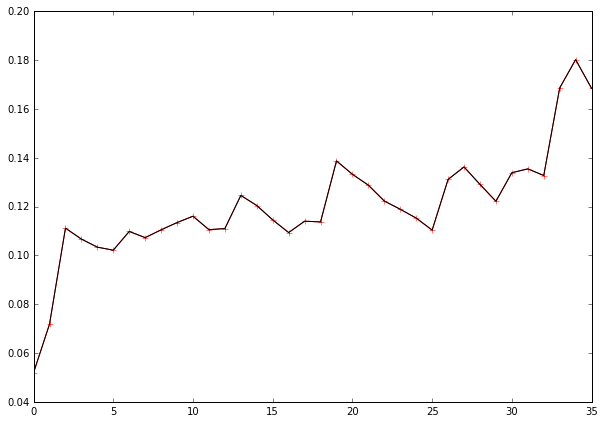

In [930]:
#Vs = V.eval({I:trainX.transpose((0,2,1))[100:(100+batch_size),:,:].astype('float32')*F})*math.sqrt(255)/F
Vs0 = modelV.predict( trainX.transpose((0,2,1))[50:(50+batch_size),:,:].astype('float32')*F )*math.sqrt(255)/F
Vs1 = modelV.predict( trainX.transpose((0,2,1))[51:(51+batch_size),:,:].astype('float32')*F )*math.sqrt(255)/F
Vs2 = modelV.predict( trainX.transpose((0,2,1))[52:(52+batch_size),:,:].astype('float32')*F )*math.sqrt(255)/F
Vs = np.vstack([Vs0,Vs1,Vs2])
#np.squeeze(Vs.reshape((1,-1)))#[0:20,0], Vs[0,:], Vs[1,:]
#Vs[0:3,:]
plt.figure(figsize=(10,7))
plt.plot( np.sqrt(np.array(check_vars)*255), c='red', marker='+' )
plt.plot( np.squeeze(Vs.reshape((1,-1)), axis=0), c='black' )

#### Compute the model Loss before training to insure loss goes down

In [931]:
test_arr = trainX.transpose((0,2,1))[50:(50+batch_size),:,:].astype('float32')
ErrorStart = np.sum(Errors.eval({I:test_arr*F }))
print(ErrorStart)

16.2256


In [932]:
print( modelT.predict(trainX.transpose((0,2,1))[50:(50+batch_size),:,:]*F)[0] )
print('-------------------------')
print( modelV.predict(trainX.transpose((0,2,1))[50:(50+batch_size),:,:]*F)[0]*math.sqrt(255)/F )

[ 1.59087622  2.58123779  1.27049232  1.23480713  1.25342405  1.65424097
  1.19713271  1.46405625  1.48231244  1.4895097   1.00750184]
-------------------------
[ 0.12847637  0.12997921  0.14942044  0.14090674  0.13375179  0.12865709
  0.13137662  0.12620793  0.12633722  0.12674068  0.12719566  0.12051097]


In [933]:
max_batches = int(trainX.transpose((0,2,1)).shape[0]/batch_size)
max_batches

166

#### A few runs of training for sanity checks

In [934]:
modelT.optimizer.lr.set_value(1e-1) # 1e-3 seems too large !
#modelT.optimizer.lr.get_value()

In [935]:
Ydummy = trainX.transpose((0,2,1))
#print(Ydummy.shape)
#print( trainX.transpose((0,2,1)).shape )
hist0 = modelT.fit(trainX.transpose((0,2,1))[0:(max_batches*batch_size),:,:]*F,
                   Ydummy[0:(max_batches*batch_size),0:-1,0],
                   epochs=10,
                   batch_size=batch_size,
                   shuffle=False,
                   verbose=0)

#### Compare Trained-Loss to check it did not worsen

In [936]:
test_arr = trainX.transpose((0,2,1))[50:50+batch_size:,:].astype('float32')
ErrorEnd = np.sum(Errors.eval({I:test_arr*F}))
print(ErrorStart, ErrorEnd)

16.2256 16.5544


#### Compare long-term vol to check similarity

In [937]:
math.sqrt(rnn.get_weights()[2][0]/(1-rnn.get_weights()[0][0][0]-rnn.get_weights()[1][0][0])*255)/F

0.1238502836849362

In [938]:
kappa*F*F, rnn.get_weights()[2][0], rnn.get_weights()[0][0][0], rnn.get_weights()[1][0][0]

(0.05000000000000002, 0.051904418, 0.096673928, 0.85155326)